# MNIST classification using TensorFlow Dataset and Keras

In [1]:
from IPython.display import display, Markdown
with open('setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Define the following env variable before starting Jupyter Lab:  
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ`  
  
Start Jupyter Lab:  
`jupyter lab`  
  
Choose the proper Anaconda python environment:  
`Python [conda env:env_tensorflow]`  
    

## Import packages

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt

In [3]:
tf.version.VERSION

'2.1.0'

## List of TensorFlow Datasets available

In [4]:
# See available datasets
print(tfds.list_builders())

['abstract_reasoning', 'aeslc', 'aflw2k3d', 'amazon_us_reviews', 'arc', 'bair_robot_pushing_small', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'cmaterdb', 'cnn_dailymail', 'coco', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'cos_e', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'diabetic_retinopathy_detection', 'dmlab', 'downsampled_imagenet', 'dsprites', 'dtd', 'duke_ultrasound', 'dummy_dataset_shared_generator', 'dummy_mnist', 'emnist', 'esnli', 'eurosat', 'fashion_mnist', 'flic', 'flores', 'food101', 'gap', 'gigaword', 'glue', 'groove', 'higgs', 'horses_or_humans', 'i_naturalist2017', 'image_label_folder', 'imagenet2012', 'imagenet201

## Configuration when using Proxy

In [5]:
# For proxy be sure the above variable are setup
#os.environ['HTTPS_PROXY']
#os.environ['REQUESTS_CA_BUNDLE']

## Downloading a TensorFlow Datasets

In [6]:
ls -la ~/tensorflow_datasets

total 0
drwxr-xr-x    4 tarrade  staff   128 Feb  5 21:17 ./
drwxr-xr-x@ 153 tarrade  staff  4896 Feb  7 09:27 ../
drwxr-xr-x    3 tarrade  staff    96 Feb  5 21:17 downloads/
drwxr-xr-x    3 tarrade  staff    96 Feb  5 21:18 mnist/


In [7]:
# to remove old version, if needed
#rm -r /Users/tarrade/tensorflow_datasets/mnist/

In [8]:
# Load a given dataset by name, along with the DatasetInfo
data, info = tfds.load("mnist", with_info=True, data_dir='~/tensorflow_datasets')

## Checks and data extraction

In [9]:
info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [10]:
data

{'test': <DatasetV1Adapter shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>,
 'train': <DatasetV1Adapter shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>}

In [11]:
train_data, test_data = data['train'], data['test']

In [12]:
train_data

<DatasetV1Adapter shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [13]:
# making some sanity checks
assert isinstance(train_data, tf.data.Dataset)
assert info.features['label'].num_classes == 10
assert info.splits['train'].num_examples == 60000

In [14]:
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
10
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


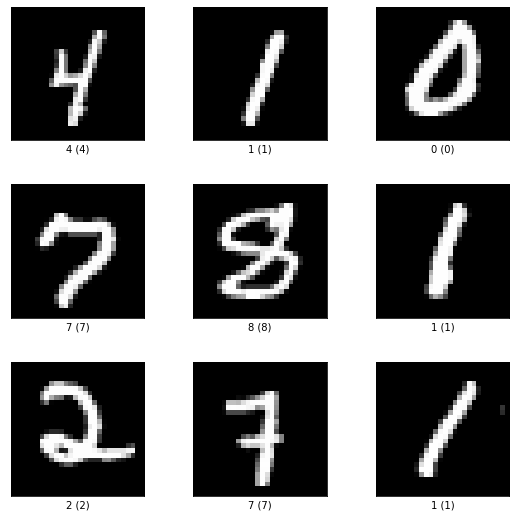

In [15]:
fig = tfds.show_examples(info, train_data)

In [16]:
train_data.take(1)

<DatasetV1Adapter shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [17]:
# training dataset
train_dataset = train_data.repeat().shuffle(1024).batch(128).prefetch(2)
train_features = tf.compat.v1.data.make_one_shot_iterator(train_dataset).get_next()
train_image, train_label = train_features['image'], train_features['label']
# testing dataset
test_dataset = test_data.repeat().shuffle(1024).batch(128).prefetch(2)
test_features = tf.compat.v1.data.make_one_shot_iterator(test_dataset).get_next()
test_image, test_label = test_features['image'], test_features['label']

In [18]:
test_features.keys()

dict_keys(['image', 'label'])

In [19]:
test_image=tf.cast(test_image, tf.float64)
train_image=tf.cast(train_image, tf.float64)

In [20]:
train_image.dtype

tf.float64

In [21]:
train_image.shape

TensorShape([128, 28, 28, 1])

In [22]:
train_image.get_shape()

TensorShape([128, 28, 28, 1])

## Model using Keras

### Build the model

In [23]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

In [24]:
model.fit(train_image, train_label, epochs=10)

Train on 128 samples
Epoch 1/10
128/128 [==============================] - 0s 2ms/sample - loss: 132.2230 - accuracy: 0.1484
Epoch 2/10
128/128 [==============================] - 0s 99us/sample - loss: 46.3221 - accuracy: 0.6016
Epoch 3/10
128/128 [==============================] - 0s 98us/sample - loss: 30.2534 - accuracy: 0.6797
Epoch 4/10
128/128 [==============================] - 0s 78us/sample - loss: 12.6261 - accuracy: 0.8750
Epoch 5/10
128/128 [==============================] - 0s 100us/sample - loss: 9.5999 - accuracy: 0.8281
Epoch 6/10
128/128 [==============================] - 0s 98us/sample - loss: 6.2613 - accuracy: 0.9062
Epoch 7/10
128/128 [==============================] - 0s 113us/sample - loss: 2.1774 - accuracy: 0.9531
Epoch 8/10
128/128 [==============================] - 0s 100us/sample - loss: 1.0242 - accuracy: 0.9844
Epoch 9/10
128/128 [==============================] - 0s 107us/sample - loss: 1.2843 - accuracy: 0.9609
Epoch 10/10
128/128 [=======================

### Evaluate the model

In [25]:
model.evaluate(test_image, test_label)

128/128 [==============================] - 0s 698us/sample - loss: 22.1131 - accuracy: 0.7656


[22.113136291503906, 0.765625]

## Other way to loading the data

In [26]:
# Load a given dataset by name, along with the DatasetInfo
mnist, info_mnist = tfds.load("mnist", with_info=True, data_dir='~/tensorflow_datasets', as_supervised=True)

In [27]:
# new
mnist, type(mnist)

({'test': <DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>,
  'train': <DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>},
 dict)

In [28]:
# old
data, type(data)

({'test': <DatasetV1Adapter shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>,
  'train': <DatasetV1Adapter shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>},
 dict)

In [29]:
mnist_train, mnist_test = mnist['train'], mnist['test']
mnist_train = mnist_train.repeat().shuffle(1024).batch(128).prefetch(2)
mnist_test = mnist_test.repeat().shuffle(1024).batch(128).prefetch(2)

In [30]:
def normalize_img(img, label):
    img = tf.cast(img, tf.float64) / 255.
    return (img, label)

In [31]:
mnist_train=mnist_train.map(normalize_img)
mnist_test=mnist_test.map(normalize_img)

In [32]:
mnist_train

<DatasetV1Adapter shapes: ((None, 28, 28, 1), (None,)), types: (tf.float64, tf.int64)>

In [33]:
mnist_test

<DatasetV1Adapter shapes: ((None, 28, 28, 1), (None,)), types: (tf.float64, tf.int64)>

In [34]:
# batch size = 128
# nb epochs = 5
# nb event = 60000
model.fit(mnist_train, epochs=10, steps_per_epoch=468)

Train for 468 steps
Epoch 1/10
468/468 [==============================] - 6s 13ms/step - loss: 0.8601 - accuracy: 0.7946
Epoch 2/10
468/468 [==============================] - 5s 10ms/step - loss: 0.4757 - accuracy: 0.8639
Epoch 3/10
468/468 [==============================] - 5s 10ms/step - loss: 0.3695 - accuracy: 0.8924
Epoch 4/10
468/468 [==============================] - 5s 10ms/step - loss: 0.3146 - accuracy: 0.9086
Epoch 5/10
468/468 [==============================] - 5s 11ms/step - loss: 0.2731 - accuracy: 0.9200
Epoch 6/10
468/468 [==============================] - 5s 10ms/step - loss: 0.2415 - accuracy: 0.9294
Epoch 7/10
468/468 [==============================] - 5s 10ms/step - loss: 0.2161 - accuracy: 0.9375
Epoch 8/10
468/468 [==============================] - 5s 11ms/step - loss: 0.1946 - accuracy: 0.9431
Epoch 9/10
468/468 [==============================] - 6s 12ms/step - loss: 0.1767 - accuracy: 0.9473
Epoch 10/10
468/468 [==============================] - 5s 11ms/step - l

In [35]:
model.evaluate(mnist_test, steps=1)

1/1 [==============================] - 0s 219ms/step - loss: 0.0561 - accuracy: 0.9844


[0.05607721209526062, 0.984375]